# Text Analysis with TF-IDF feature selection

In [2]:
!pip install --user -U nltk
!pip install gensim



import pandas as pd
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
import string  
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error
from nltk import ngrams
from nltk.tokenize import word_tokenize
from scipy import stats
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup

nltk.download('punkt')



Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
/usr/share/python-wheels/urllib3-1.25.8-py2.py3-none-any.whl/urllib3/connectionpool.py:999: InsecureRequestWarning: Unverified HTTPS request is being made to host 'pypi.ngc.nvidia.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
Requirement already up-to-date: nltk in /home/owenkutzscher/.local/lib/python3.8/site-packages (3.8.1)
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/owenkutzscher/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/owenkutzscher/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/owenkutzscher/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/owenkutzscher/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Clean the data

In [3]:
# Read the CSV file
df_extra_params = pd.read_csv("../data/Reviews.csv")

# Select only the "Score" and "Text" columns
df_unbalanced = df_extra_params[["Score", "Text"]]

# Determine minimum number of reviews for any score
min_reviews = df_unbalanced['Score'].value_counts().min()

def create_subset(data, fraction):
    subset_data = data.sample(frac=fraction)
    return subset_data

# Split the data into five groups with an equal number of reviews in each group
df_grouped = df_unbalanced.groupby('Score', group_keys=False).apply(lambda x: x.sample(min_reviews))






# Apply the fraction parameter to each group
# My computer occasionally freaks out when I make the fraction 1, so 0.9 will do for now...
fraction_to_keep = 0.9
# The data is decently uniform, don't be affraid to make it small ex: 0.1
# Also pretty sure the number of n-grams increases exponentially based on the size of the data since it it makeing
# grams out of each word (or group of words) in refrence to other words.
# As a result run time can get very long. (something that took 6 minutes with 0.3 of the data hasn't finished after 2 hours with 0.9 of the data)
df = df_grouped.groupby('Score').apply(lambda x: create_subset(x, fraction_to_keep)).reset_index(drop=True)








# Display the resulting DataFrame
df.head()

# # Display number of reviews
# print("The number of rows is", len(df))



,Score,Text
0,1,"After I purchased this, I found you could buy ..."
1,1,Have purchased these noodles for over 10 years...
2,1,"It tastes horrible, looks disgusting and waste..."
3,1,My dog won't eat these things. I can offer her...
4,1,Liked the idea of the box but the tea tasted/s...


In [4]:
# Remove NaN values and lowercase the text
df = df.dropna(subset=['Text']).copy()
df['Text'] = df['Text'].str.lower()

# Remove HTML text
df['Text'] = df['Text'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())




# Extra data cleaning (may make models perform worse, or better...)

# Lemmatization (Reduce words to their base)
lemmatizer = WordNetLemmatizer()
df['Text'] = df['Text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

# Remove Punctuation
df['Text'] = df['Text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Drop noisy text, such as special characters, numbers, or other non-text elements.
df['Text'] = df['Text'].str.replace(r'[^a-zA-Z\s]', '', regex=True)

# If you try to print the word cloud after uncommenting below it will crash the kernal!
# Remove Common Stop Words (“a,” “the,” “is,” “are,” etc.)
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
df['Text'] = df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))




# Display the resulting DataFrame
df.head()

/tmp/ipykernel_19000/2150099249.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  df['Text'] = df['Text'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())


,Score,Text
0,1,purchased found could buy local safeway half p...
1,1,purchased noodle years never problemthe entire...
2,1,taste horrible look disgusting waste money tim...
3,1,dog wont eat things offer nothing else eat day...
4,1,liked idea box tea tastedsmelled like glue pai...


In [5]:
# split into train and test sets

X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['Score'], test_size=0.2)


### Use TF-IDF to vectroize the text

In [6]:
# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

# Fit and transform on the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Using models to classify reviews

### Models used: Random Forest, SVM, Naive Bayesian Classifier

# Using models to classify reviews

### Models used: Random Forest, SVM, Naive Bayesian Classifier

I'll be measuring performance using Accuracy (becuase its literally acuracy)
and Normalized Root Mean Squared Error
since it gives a good measure of how good the model is at
predicting around the right answer. 

NRMS is a good metric becuase many reviews are similar and overall review
ratings are by nature are a little inconsistent and noisy.
Humans are just inconsistent at rating things lol.
Ex: This Batman toy was ok for my son. He enjoyed playing with it for a couple days
Predicted stars: 3
Actual stars: 2

### Random Forest

Accuracy: 0.6182069274410271
Model is off by an average of 1.145212163215076 stars (RMSE)
Normalized RMSE: 0.286303040803769


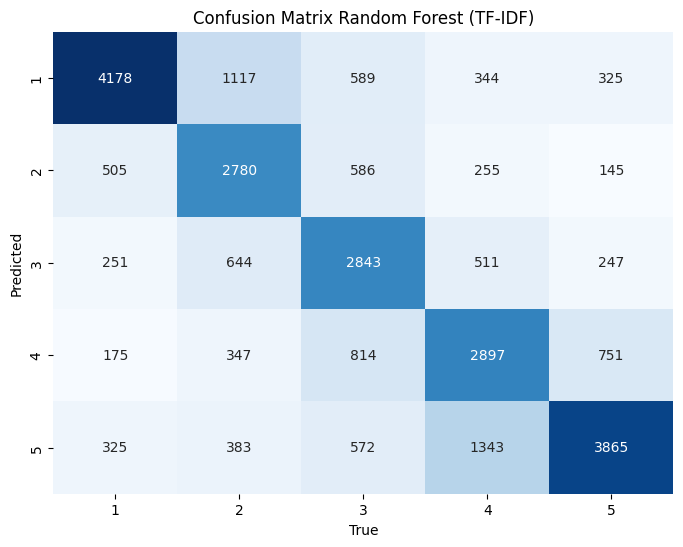

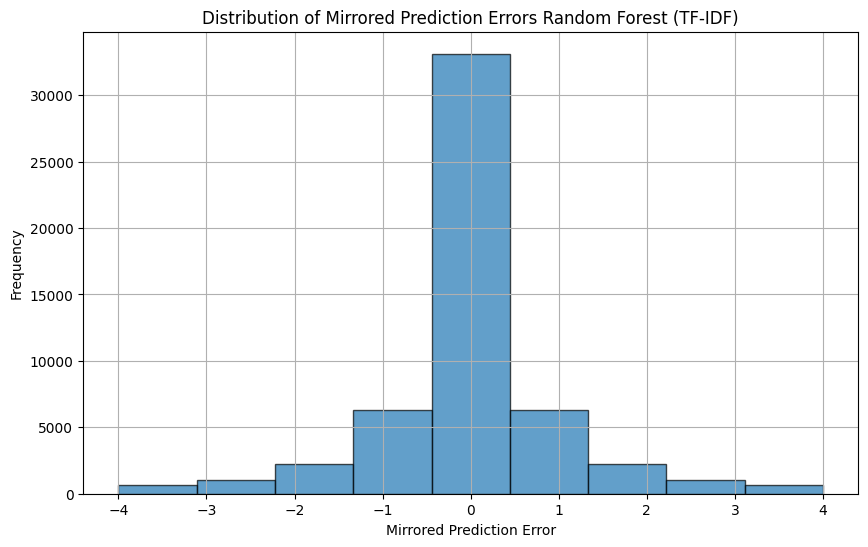

In [8]:
# Train the Random Forest Classifier

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=69)
# rf_classifier = RandomForestClassifier(n_estimators=100, random_state=69)
rf_classifier.fit(X_train_tfidf, y_train)


# Evaluate the Model

y_pred = rf_classifier.predict(X_test_tfidf)



print("Accuracy:", accuracy_score(y_test, y_pred))
# print("\nClassification Report:\n", classification_report(y_test, y_pred))




# Root mean squared error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Model is off by an average of", rmse, "stars (RMSE)")
normalized_rmse = rmse / (max(y_test) - min(y_test))
print("Normalized RMSE:", normalized_rmse)




# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a DataFrame for the confusion matrix
conf_matrix_df = pd.DataFrame(conf_matrix, index=range(1, 6), columns=range(1, 6))

# Display the raw confusion matrix
# print("\nConfusion Matrix:\n", conf_matrix_df)

# Create a heatmap using seaborn with swapped axes
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df.T, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix Random Forest (TF-IDF)')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()




# Calculate prediction errors
errors = y_pred - y_test

# Create a mirrored version of the errors
mirrored_errors = -errors

# Concatenate the original and mirrored errors
all_errors = np.concatenate([errors, mirrored_errors])

# Plot histogram of errors
plt.figure(figsize=(10, 6))
plt.hist(all_errors, bins=9, edgecolor='black', alpha=0.7)
plt.title('Distribution of Mirrored Prediction Errors Random Forest (TF-IDF)')
plt.xlabel('Mirrored Prediction Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


### SVM: SVC (Support Vector Classification)

In [7]:
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.kernel_approximation import Nystroem
from sklearn.svm import SVC


Accuracy: 0.5351224246043595
Model is off by an average of 1.116798093429162 stars (RMSE)
Normalized RMSE: 0.2791995233572905


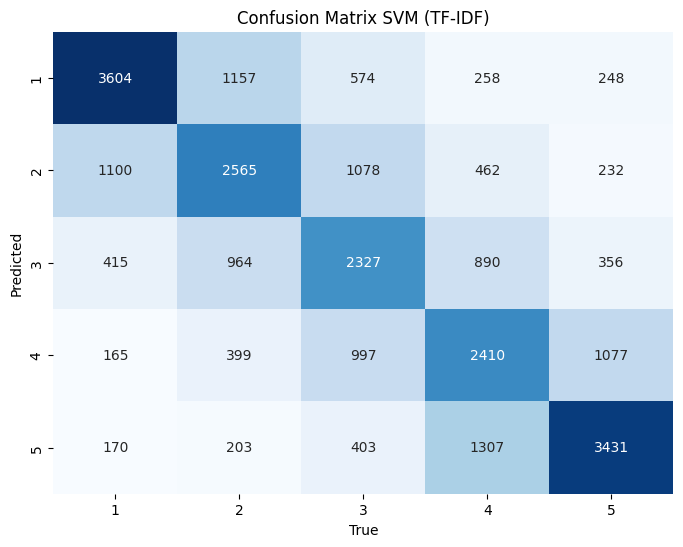

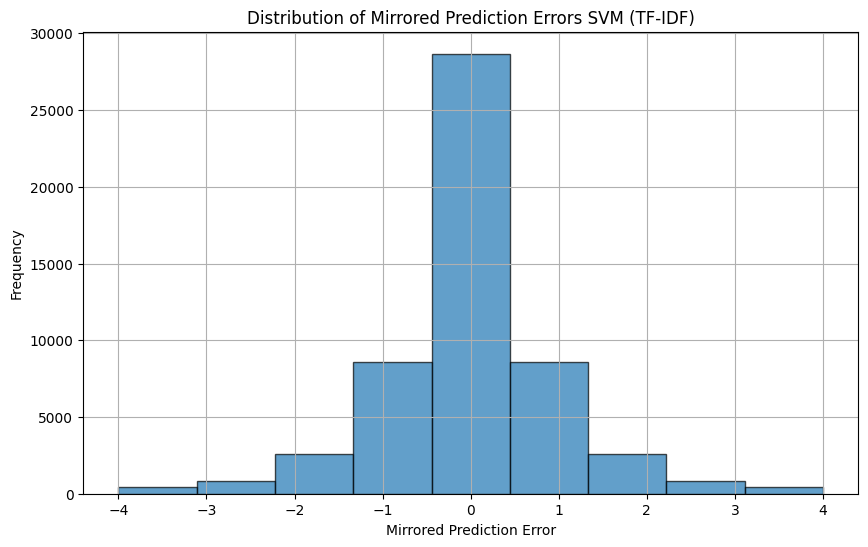

In [8]:
# First lets test out some SVCs
# Using TfidfVectorizer instead of CountVectorizer makes almost no difference in performance



# Create an SVM classifier

# C-Support Vector Classification
svm_classifier = SVC(kernel='linear')  # You can choose different kernels like 'linear', 'rbf', 'poly', etc.
"""
# Linear Support Vector Classification (not as good but way faster to train!)
# This becomes VERY accurate on large ammounts of data! And it's still super fast to train!
svm_classifier = LinearSVC()
"""

# Train the SVM classifier
svm_classifier.fit(X_train_tfidf, y_train)




# Overall the SVM model performs great
# It performs differently than the random forest

# It's like this: Random Forest predicts the correct review more often, but when it's wrong, its often far off from the correct value
# SVM doesn't predict the correct review as often, but it's never very off from the correct value
# Also, compared to the Random Forest it is better at predicting 2,3,4 star reviews
# and worse at predicting 1 and 5 star reviews

# On larger ammounts of data it performs better than random forest including in terms of accuracy!


# Make predictions on the test set
y_pred = svm_classifier.predict(X_test_tfidf)


'''
# Sanity check: check out the crazy outliars
# Make sure it makes a little bit of sense that the model is predicting some 5 star reviews as 1 and vise versa
# Print the reviews for heavy outliers, at most 10 for each category
count_1_star = 0
count_5_star = 0

for true_label, predicted_label, review_text in zip(y_test, y_pred, X_test):
    if true_label == 5 and predicted_label == 1 and count_5_star < 3:
        print("\nPredicted: 1 star, True: 5 stars\nReview Text:", review_text)
        count_5_star += 1
    elif true_label == 1 and predicted_label == 5 and count_1_star < 3:
        print("\nPredicted: 5 stars, True: 1 star\nReview Text:", review_text)
        count_1_star += 1
'''


print("Accuracy:", accuracy_score(y_test, y_pred))
# print("\nClassification Report:\n", classification_report(y_test, y_pred))



# Root mean squared error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Model is off by an average of", rmse, "stars (RMSE)")
normalized_rmse = rmse / (max(y_test) - min(y_test))
print("Normalized RMSE:", normalized_rmse)




# From this hart we can see that the model is the best at predicting 1 and 5 star reviews
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a DataFrame for the confusion matrix
conf_matrix_df = pd.DataFrame(conf_matrix, index=range(1, 6), columns=range(1, 6))

# Display the raw confusion matrix
# print("\nConfusion Matrix:\n", conf_matrix_df)

# Create a heatmap using seaborn with swapped axes
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df.T, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix SVM (TF-IDF)')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()





# Calculate prediction errors
errors = y_pred - y_test

# Create a mirrored version of the errors
mirrored_errors = -errors

# Concatenate the original and mirrored errors
all_errors = np.concatenate([errors, mirrored_errors])

# Plot histogram of errors
plt.figure(figsize=(10, 6))
plt.hist(all_errors, bins=9, edgecolor='black', alpha=0.7)
plt.title('Distribution of Mirrored Prediction Errors SVM (TF-IDF)')
plt.xlabel('Mirrored Prediction Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


Accuracy: 0.4601746790086593
Model is off by an average of 1.3086209545271885 stars (RMSE)
Normalized RMSE: 0.32715523863179713


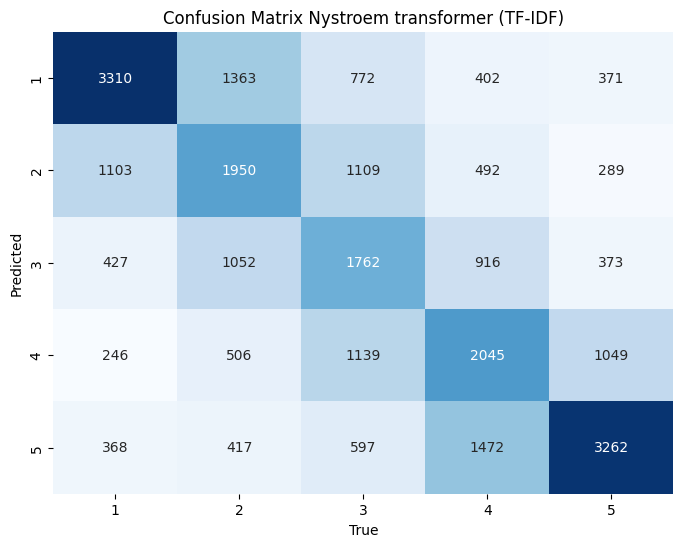

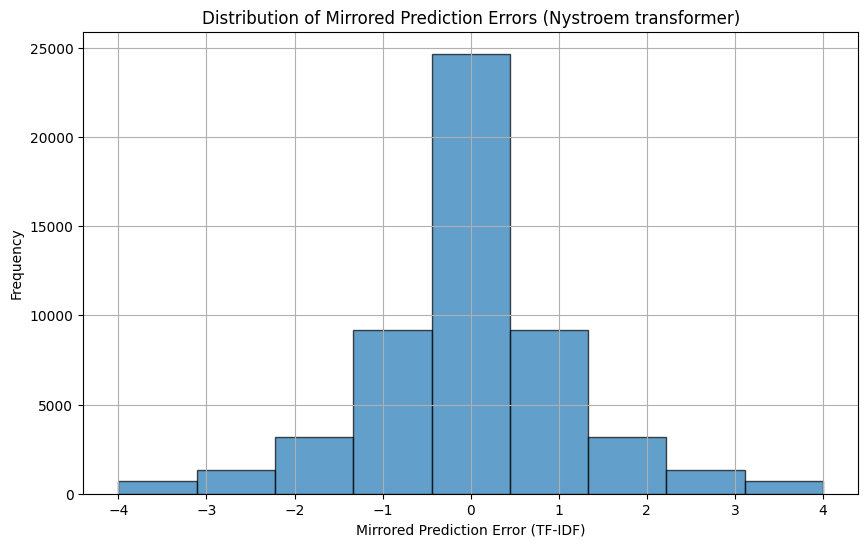

In [9]:
# Lets use a Nystroem transformer so we can train on more data

# NOTE Oh god this makes the model perform horribly!!
# The model is good at predicting 1 and 5 star reviews but nothing else!
# It it especially bad at 3 star reviews now, predicting barley any of them correctly

# First we will use a kernal approximator so we can train on a large ammount of data quickly

# Use Nystroem to approximate the kernel matrix (data gets manipulated, makes it so the kernal can )
nystroem_transformer = Nystroem(kernel='linear', n_components=500, random_state=69)
X_train_nystroem = nystroem_transformer.fit_transform(X_train_tfidf)
X_test_nystroem = nystroem_transformer.transform(X_test_tfidf)
# Expiraments: n_components= 300 horrible barley gets anything right as far as 3 star reviews!! 
# 600 horrible and doesn't get really anything right, appears to guess randomly, but good at guessing 5 star reviews
# 200 




# Create an SVM classifier

# C-Support Vector Classification (with the Nystroem stuff this takes twice as long to train than with no Nystroem)
svm_classifier = SVC(kernel='linear')  # You can choose different kernels like 'linear', 'rbf', 'poly', etc.
# I am not going to use this for an example because it takes such a long time to train 
"""
# Linear Support Vector Classification (not as good but way faster to train!)
svm_classifier = LinearSVC()
"""


# Train the SVM classifier
svm_classifier.fit(X_train_nystroem, y_train)




# Make predictions on the test set
y_pred = svm_classifier.predict(X_test_nystroem)


print("Accuracy:", accuracy_score(y_test, y_pred))
# print("\nClassification Report:\n", classification_report(y_test, y_pred))


# Root mean squared error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Model is off by an average of", rmse, "stars (RMSE)")
normalized_rmse = rmse / (max(y_test) - min(y_test))
print("Normalized RMSE:", normalized_rmse)



# From this hart we can see that the model is the best at predicting 1 and 5 star reviews
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a DataFrame for the confusion matrix
conf_matrix_df = pd.DataFrame(conf_matrix, index=range(1, 6), columns=range(1, 6))

# Display the raw confusion matrix
# print("\nConfusion Matrix:\n", conf_matrix_df)

# Create a heatmap using seaborn with swapped axes
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df.T, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix Nystroem transformer (TF-IDF)')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()


# Calculate prediction errors
errors = y_pred - y_test

# Create a mirrored version of the errors
mirrored_errors = -errors

# Concatenate the original and mirrored errors
all_errors = np.concatenate([errors, mirrored_errors])

# Plot histogram of errors
plt.figure(figsize=(10, 6))
plt.hist(all_errors, bins=9, edgecolor='black', alpha=0.7)
plt.title('Distribution of Mirrored Prediction Errors (Nystroem transformer)')
plt.xlabel('Mirrored Prediction Error (TF-IDF)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


### Naive Bayesian Classifier

In [12]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import accuracy_score, classification_report

# Note the NB models load up in under a second!!!

In [13]:
# Initialize the Multinomial Naive Bayes classifier
classifier_MultinomialNB = MultinomialNB()

# Train the classifier
classifier_MultinomialNB.fit(X_train_tfidf, y_train)

MultinomialNB()

Accuracy: 0.4925724096745297
Model is off by an average of 1.2142468208289048 stars (RMSE)
Normalized RMSE: 0.3035617052072262


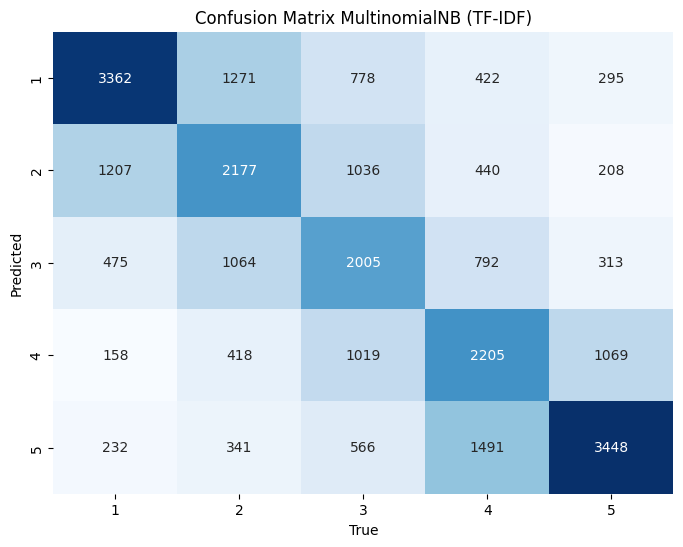

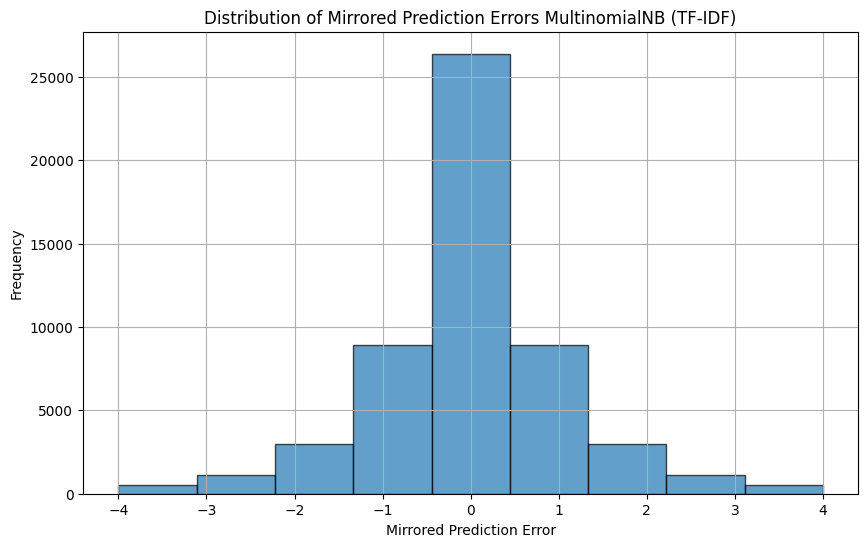

In [14]:
# Model performance


# Make predictions on the test set
y_pred = classifier_MultinomialNB.predict(X_test_tfidf)



'''
# Sanity check: check out the crazy outliars
# Make sure it makes a little bit of sense that the model is predicting some 5 star reviews as 1 and vise versa
# Print the reviews for heavy outliers, at most 10 for each category
count_1_star = 0
count_5_star = 0

for true_label, predicted_label, review_text in zip(y_test, y_pred, X_test):
    if true_label == 5 and predicted_label == 1 and count_5_star < 3:
        print("\nPredicted: 1 star, True: 5 stars\nReview Text:", review_text)
        count_5_star += 1
    elif true_label == 1 and predicted_label == 5 and count_1_star < 3:
        print("\nPredicted: 5 stars, True: 1 star\nReview Text:", review_text)
        count_1_star += 1
'''





print("Accuracy:", accuracy_score(y_test, y_pred))
# print("\nClassification Report:\n", classification_report(y_test, y_pred))


# Root mean squared error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Model is off by an average of", rmse, "stars (RMSE)")
normalized_rmse = rmse / (max(y_test) - min(y_test))
print("Normalized RMSE:", normalized_rmse)




# From this hart we can see that the model is the best at predicting 1 and 5 star reviews
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a DataFrame for the confusion matrix
conf_matrix_df = pd.DataFrame(conf_matrix, index=range(1, 6), columns=range(1, 6))

# Display the raw confusion matrix
# print("\nConfusion Matrix:\n", conf_matrix_df)

# Create a heatmap using seaborn with swapped axes
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df.T, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix MultinomialNB (TF-IDF)')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()



# Calculate prediction errors
errors = y_pred - y_test

# Create a mirrored version of the errors
mirrored_errors = -errors

# Concatenate the original and mirrored errors
all_errors = np.concatenate([errors, mirrored_errors])

# Plot histogram of errors
plt.figure(figsize=(10, 6))
plt.hist(all_errors, bins=9, edgecolor='black', alpha=0.7)
plt.title('Distribution of Mirrored Prediction Errors MultinomialNB (TF-IDF)')
plt.xlabel('Mirrored Prediction Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


Accuracy: 0.4800313526425799
Model is off by an average of 1.3180704247763284 stars (RMSE)
Normalized RMSE: 0.3295176061940821


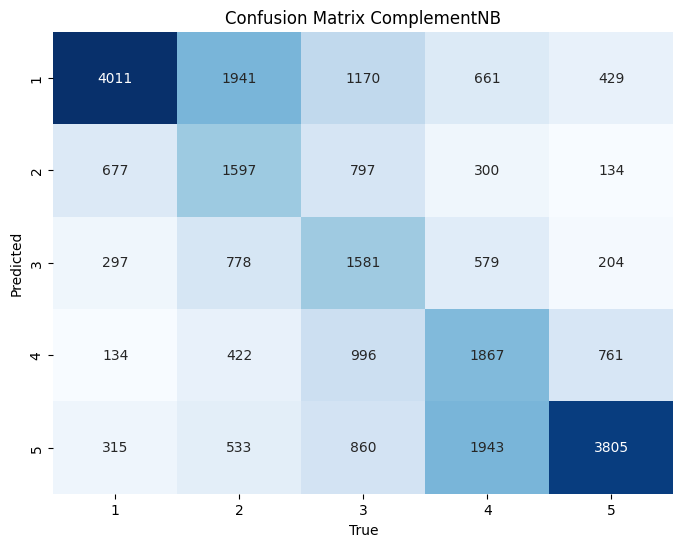

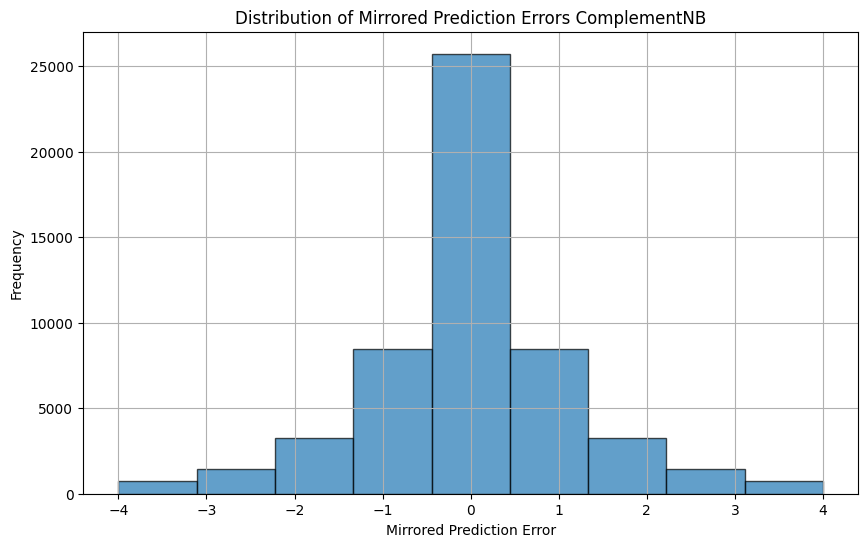

In [15]:

# This model's performance does not increase by changing CountVectorizer to TfidfVectorizer

# Train the Complement Naive Bayes Classifier
classifier_ComplementNB = ComplementNB()
classifier_ComplementNB.fit(X_train_tfidf, y_train)



# Model performance
# Wow!! performs nearly just as good as SVM but takes 0 seconds to train, even on the entire data set!!!


# Make predictions on the test set
y_pred = classifier_ComplementNB.predict(X_test_tfidf)



'''
# Sanity check: check out the crazy outliars
# Make sure it makes a little bit of sense that the model is predicting some 5 star reviews as 1 and vise versa
# Print the reviews for heavy outliers, at most 10 for each category
count_1_star = 0
count_5_star = 0

for true_label, predicted_label, review_text in zip(y_test, y_pred, X_test):
    if true_label == 5 and predicted_label == 1 and count_5_star < 3:
        print("\nPredicted: 1 star, True: 5 stars\nReview Text:", review_text)
        count_5_star += 1
    elif true_label == 1 and predicted_label == 5 and count_1_star < 3:
        print("\nPredicted: 5 stars, True: 1 star\nReview Text:", review_text)
        count_1_star += 1
'''





print("Accuracy:", accuracy_score(y_test, y_pred))
# print("\nClassification Report:\n", classification_report(y_test, y_pred))





# Root mean squared error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Model is off by an average of", rmse, "stars (RMSE)")
normalized_rmse = rmse / (max(y_test) - min(y_test))
print("Normalized RMSE:", normalized_rmse)




# From this hart we can see that the model is the best at predicting 1 and 5 star reviews
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a DataFrame for the confusion matrix
conf_matrix_df = pd.DataFrame(conf_matrix, index=range(1, 6), columns=range(1, 6))

# Display the raw confusion matrix
# print("\nConfusion Matrix:\n", conf_matrix_df)

# Create a heatmap using seaborn with swapped axes
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df.T, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix ComplementNB')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()





# Calculate prediction errors
errors = y_pred - y_test

# Create a mirrored version of the errors
mirrored_errors = -errors

# Concatenate the original and mirrored errors
all_errors = np.concatenate([errors, mirrored_errors])

# Plot histogram of errors
plt.figure(figsize=(10, 6))
plt.hist(all_errors, bins=9, edgecolor='black', alpha=0.7)
plt.title('Distribution of Mirrored Prediction Errors ComplementNB')
plt.xlabel('Mirrored Prediction Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
